##  <u>References and sources </u>

Yulia Newton code examples <br>
https://www.kaggle.com/code/rajmehra03/flower-recognition-cnn-keras


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import matplotlib.pyplot as plt
import pydot
from skimage import io
import numpy as np
import zipfile

In [ ]:
np.random.seed(42)

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/homework8_input_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')

In [ ]:
image_size = (180, 180)
batch_size = 1



test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/flowers/test",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

test_predictions = np.array([])
test_labels =  np.array([])


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/flowers/training",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,

)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/flowers/test",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
)

Found 861 files belonging to 5 classes.
Using 172 files for validation.
Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 861 files belonging to 5 classes.
Using 172 files for validation.


In [ ]:
train_ds.cardinality

<bound method DatasetV2.cardinality of <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>>

In [ ]:
train_ds.class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

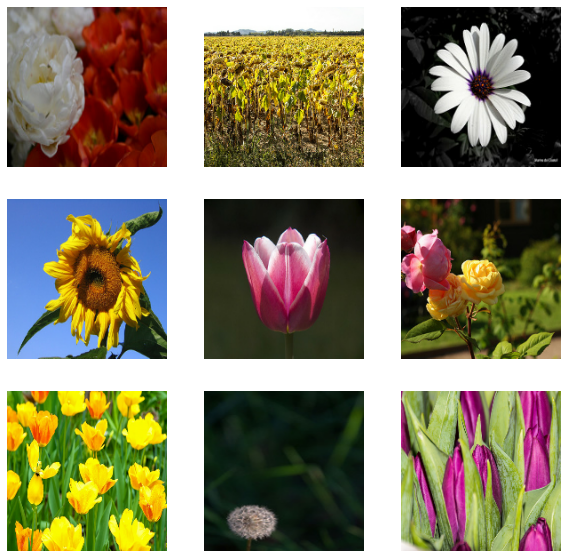

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
data_augmentation = keras.Sequential(
    [
        
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

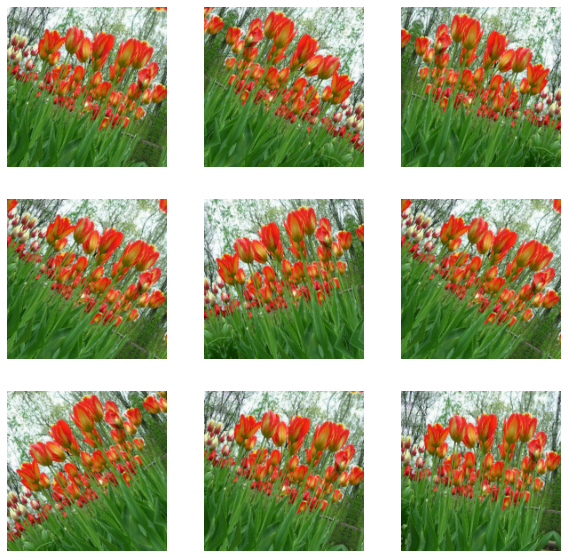

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 614s 7s/step - loss: 1.2526 - accuracy: 0.5400 - val_loss: 1.7546 - val_accuracy: 0.2151
Epoch 2/20
87/87 [==============================] - 501s 6s/step - loss: 1.0261 - accuracy: 0.6199 - val_loss: 2.3645 - val_accuracy: 0.2151
Epoch 3/20
87/87 [==============================] - 506s 6s/step - loss: 0.9057 - accuracy: 0.6705 - val_loss: 3.2104 - val_accuracy: 0.2151
Epoch 4/20
87/87 [==============================] - 508s 6s/step - loss: 0.8638 - accuracy: 0.6734 - val_loss: 3.5492 - val_accuracy: 0.2151
Epoch 5/20
87/87 [==============================] - 504s 6s/step - loss: 0.7680 - accuracy: 0.7172 - val_loss: 3.9505 - val_accuracy: 0.2151
Epoch 6/20
87/87 [==============================] - 503s 6s/step - loss: 0.7129 - accuracy: 0.7298 - val_loss: 2.3382 - val_accuracy: 0.2733
Epoch 7/20
87/87 [==============================] - 507s 6s/step - loss: 0.7197 - accuracy: 0.7291 - val_loss: 1.2885 - val_accuracy: 0.5523
Epoch 8/20
87

In [ ]:
for img, label in test_ds.take(2):
  img_array = keras.preprocessing.image.img_to_array(img[0])
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  test_actual = label[0]
  




1/1 [==============================] - 0s 67ms/step


In [ ]:
print(tf.round(score))
test_actual

tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 1., 0.], dtype=float32)>

In [ ]:
test_ds.class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

1/1 [==============================] - 0s 65ms/step


<Figure size 720x720 with 0 Axes>

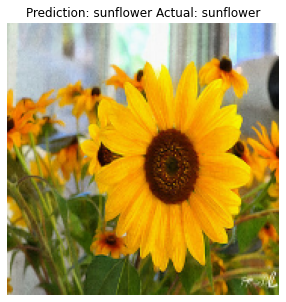

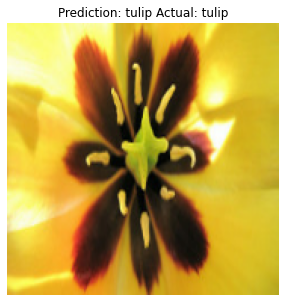

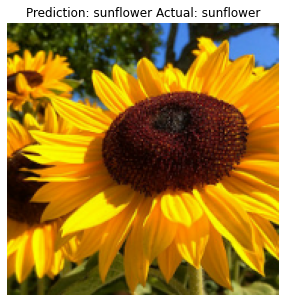

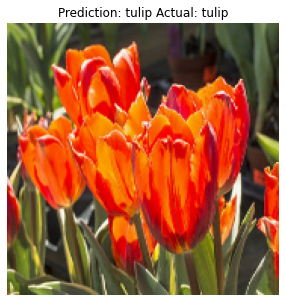

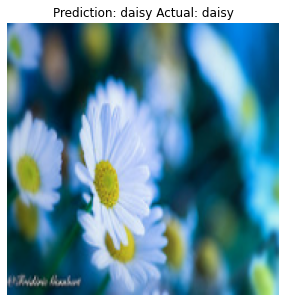

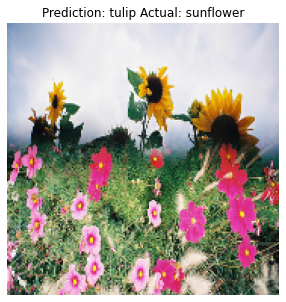

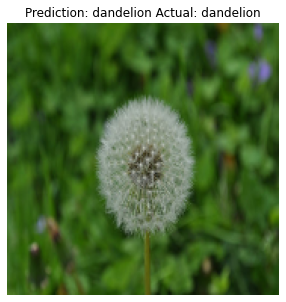

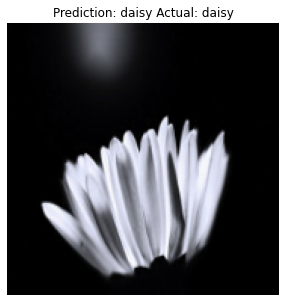

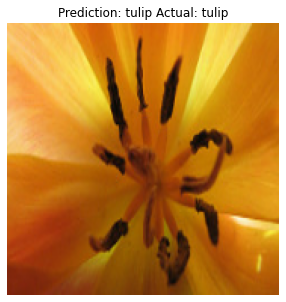

In [ ]:
plt.figure(figsize=(10, 10))
for img, label in test_ds.take(9):
  plt.figure(figsize=(8, 5))
  plt.axis("off")
  
  img_array = keras.preprocessing.image.img_to_array(img[0])
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array)
  score = predictions[0]
  if score.max() == score[0]:
    # print('This is a daisy')
    name = 'daisy'
  if score.max() == score[1]:
    # print('This is a dandelion')
    name = 'dandelion'
  if score.max() == score[2]:
    # print('This is a rose')
    name = 'rose'
  if score.max() == score[3]:
    # print('This is a sunflower')
    name = 'sunflower'
  if score.max() == score[4]:
    # print('This is a tulip')
    name = 'tulip'

  if label[0][0] == 1:
    # print('This is a daisy')
    actual = 'daisy'
  if label[0][1] == 1:
    # print('This is a dandelion')
    actual = 'dandelion'
  if label[0][2] == 1:
    # print('This is a rose')
    actual = 'rose'
  if label[0][3] == 1:
    # print('This is a sunflower')
    actual = 'sunflower'
  if label[0][4] == 1:
    # print('This is a tulip')
    actual = 'tulip'

  plt.title("Prediction: "+ name + " Actual: " + actual)
  plt.imshow(img[0].numpy().astype("uint8"))



In [ ]:
test_predictions = []
test_labels =  []
type(test_predictions)
predictions2 = np.array([])
labels2 = np.array([])

In [ ]:
for img, label in test_ds:
  img_array = keras.preprocessing.image.img_to_array(img[0])
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array)
  # predictions2 = np.concatenate([predictions2, model.predict(img_array)])
  labels2 = np.concatenate([labels2, np.argmax(label.numpy(), axis= -1)])
  score = predictions[0]
  # predictions2 = np.concatenate([predictions2, tf.round(score)])
  if score.max() == score[0]:
    # print('This is a daisy')
    # print(tf.round(score))
    test_predictions.append(tf.round(score))
    predictions2 = np.concatenate([predictions2, [0]], axis=-1)
    name = 'daisy'
  if score.max() == score[1]:
    test_predictions.append(tf.round(score))
    predictions2 = np.concatenate([predictions2, [1]], axis=-1)
    # print('This is a dandelion')
    name = 'dandelion'
  if score.max() == score[2]:
    test_predictions.append(tf.round(score))
    predictions2 = np.concatenate([predictions2, [2]], axis=-1)
    # print('This is a rose')
    name = 'rose'
  if score.max() == score[3]:
    test_predictions.append(tf.round(score))
    predictions2 = np.concatenate([predictions2, [3]], axis=-1)
    # print('This is a sunflower')
    name = 'sunflower'
  if score.max() == score[4]:
    test_predictions.append(tf.round(score))
    predictions2 = np.concatenate([predictions2, [4]], axis=-1)
    # print('This is a tulip')
    name = 'tulip'

  if label[0][0] == 1:
    # print('This is a daisy')
    test_labels.append(label[0])
    actual = 'daisy'
  if label[0][1] == 1:
    # print('This is a dandelion')
    test_labels.append(label[0])
    actual = 'dandelion'
  if label[0][2] == 1:
    # print('This is a rose')
    test_labels.append(label[0])
    actual = 'rose'
  if label[0][3] == 1:
    # print('This is a sunflower')
    test_labels.append(label[0])
    actual = 'sunflower'
  if label[0][4] == 1:
    # print('This is a tulip')
    test_labels.append(label[0])
    actual = 'tulip'

1/1 [==============================] - 0s 69ms/step


In [ ]:
cm = tf.math.confusion_matrix(labels=labels2, predictions=predictions2).numpy()
cm

array([[44, 10,  6,  0,  4],
       [ 4, 58,  4,  2,  6],
       [ 6,  0, 44,  0, 22],
       [ 6, 10,  4, 34,  4],
       [ 2,  2, 12,  0, 60]], dtype=int32)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


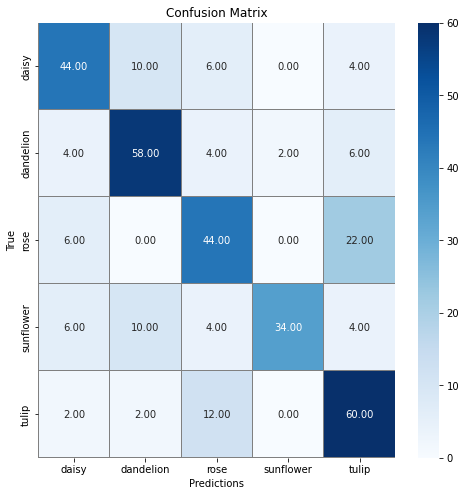

In [ ]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.2f',ax=ax, xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel("Predictions")
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 63ms/step


<Figure size 720x720 with 0 Axes>

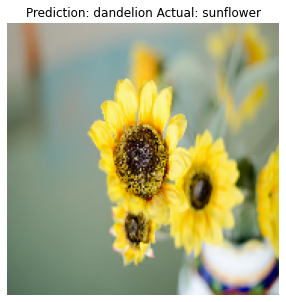

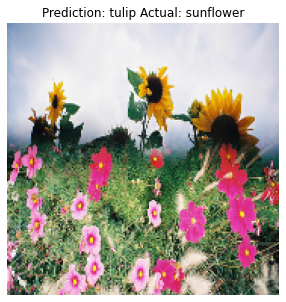

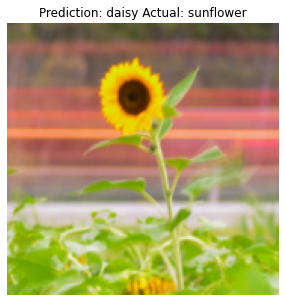

In [ ]:
total = 3
count = 0
plt.figure(figsize=(10, 10))
for img, label in test_ds.take(19):
  img_array = keras.preprocessing.image.img_to_array(img[0])
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array)
  score = predictions[0]
  if score.max() == score[0]:
    # print('This is a daisy')
    name = 'daisy'
  if score.max() == score[1]:
    # print('This is a dandelion')
    name = 'dandelion'
  if score.max() == score[2]:
    # print('This is a rose')
    name = 'rose'
  if score.max() == score[3]:
    # print('This is a sunflower')
    name = 'sunflower'
  if score.max() == score[4]:
    # print('This is a tulip')
    name = 'tulip'
  if label[0][0] == 1:
    # print('This is a daisy')
    actual = 'daisy'
  if label[0][1] == 1:
    # print('This is a dandelion')
    actual = 'dandelion'
  if label[0][2] == 1:
    # print('This is a rose')
    actual = 'rose'
  if label[0][3] == 1:
    # print('This is a sunflower')
    actual = 'sunflower'
  if label[0][4] == 1:
    # print('This is a tulip')
    actual = 'tulip'
  if name != actual:
    if count < total:
      count+=1
      plt.figure(figsize=(8, 5))
      plt.axis("off")
      plt.title("Prediction: "+ name + " Actual: " + actual)
      plt.imshow(img[0].numpy().astype("uint8"))
